In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdate
from functions import read_merge_prepare_data, train_test_random_forest_rolling

In [2]:
 # Setting display options to show all columns without truncation
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [3]:
periods = ['Q1', 'Q2', 'Q3', 'A1', 'A2']

In [4]:
macro_file_path = "data/processed_data/macro_data.csv"
Macro_Data = pd.read_csv(macro_file_path)

# Create an empty dictionary to store DataFrames
forecast_data = {}

# Read CSV files into DataFrames and store them in the dictionary
for forecast in periods:
    forecast_data[forecast] = read_merge_prepare_data(forecast, Macro_Data)


Q1 Missing Values:
price     9
ret      37
dtype: int64
 len extreme data droped 1335
len data 924600
Q2 Missing Values:
price     9
ret      34
dtype: int64
 len extreme data droped 1110
len data 840643
Q3 Missing Values:
price     9
ret      28
dtype: int64
 len extreme data droped 938
len data 770600
A1 Missing Values:
price    13
ret      44
dtype: int64
 len extreme data droped 8679
len data 972270
A2 Missing Values:
price     7
ret      27
dtype: int64
 len extreme data droped 9003
len data 826732


# Rolling window Random Forest

In [5]:
results_rolling = {}

# note: run 18 min for Q1 with 1% sample
for forecast, df in forecast_data.items():
    print(forecast)
    results_rolling[forecast] = train_test_random_forest_rolling(forecast, df)

Q1


/Users/arianna/Documents/master/2023-2024/thesis/Man-vs-machine/functions.py:93: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  y_hat_test = pd.Series()


train btw 1985-01 and 1985-12
test on 1986-01
Q1
test data length 1245
 min y train -9.6
 max y train 5.4
Training Random Forest
Random Forest training completed
 len prediciton 1245
train btw 1985-02 and 1986-01
test on 1986-02
Q1
test data length 1231
 min y train -9.6
 max y train 5.4
Training Random Forest
Random Forest training completed
 len prediciton 2476
train btw 1985-03 and 1986-02
test on 1986-03
Q1
test data length 1243
 min y train -9.6
 max y train 5.4
Training Random Forest
Random Forest training completed
 len prediciton 3719
train btw 1985-04 and 1986-03
test on 1986-04
Q1
test data length 1260
 min y train -9.6
 max y train 5.4
Training Random Forest
Random Forest training completed
 len prediciton 4979
train btw 1985-05 and 1986-04
test on 1986-05
Q1
test data length 1218
 min y train -9.6
 max y train 5.4
Training Random Forest
Random Forest training completed
 len prediciton 6197
train btw 1985-06 and 1986-05
test on 1986-06
Q1
test data length 1260
 min y train -

/Users/arianna/Documents/master/2023-2024/thesis/Man-vs-machine/functions.py:93: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  y_hat_test = pd.Series()


train btw 1985-01 and 1985-12
test on 1986-01
Q2
test data length 1100
 min y train -9.6
 max y train 5.4
Training Random Forest
Random Forest training completed
 len prediciton 1100
train btw 1985-02 and 1986-01
test on 1986-02
Q2
test data length 1087
 min y train -9.6
 max y train 5.4
Training Random Forest
Random Forest training completed
 len prediciton 2187
train btw 1985-03 and 1986-02
test on 1986-03
Q2
test data length 1083
 min y train -9.6
 max y train 5.4
Training Random Forest
Random Forest training completed
 len prediciton 3270
train btw 1985-04 and 1986-03
test on 1986-04
Q2
test data length 1086
 min y train -8.27
 max y train 5.4
Training Random Forest
Random Forest training completed
 len prediciton 4356
train btw 1985-05 and 1986-04
test on 1986-05
Q2
test data length 1072
 min y train -8.27
 max y train 5.4
Training Random Forest
Random Forest training completed
 len prediciton 5428
train btw 1985-06 and 1986-05
test on 1986-06
Q2
test data length 1082
 min y train

/Users/arianna/Documents/master/2023-2024/thesis/Man-vs-machine/functions.py:93: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  y_hat_test = pd.Series()


train btw 1985-01 and 1985-12
test on 1986-01
Q3
test data length 996
 min y train -8.27
 max y train 6.0
Training Random Forest
Random Forest training completed
 len prediciton 996
train btw 1985-02 and 1986-01
test on 1986-02
Q3
test data length 953
 min y train -8.27
 max y train 6.0
Training Random Forest
Random Forest training completed
 len prediciton 1949
train btw 1985-03 and 1986-02
test on 1986-03
Q3
test data length 947
 min y train -8.27
 max y train 6.0
Training Random Forest
Random Forest training completed
 len prediciton 2896
train btw 1985-04 and 1986-03
test on 1986-04
Q3
test data length 915
 min y train -8.27
 max y train 6.0
Training Random Forest
Random Forest training completed
 len prediciton 3811
train btw 1985-05 and 1986-04
test on 1986-05
Q3
test data length 903
 min y train -8.27
 max y train 8.69
Training Random Forest
Random Forest training completed
 len prediciton 4714
train btw 1985-06 and 1986-05
test on 1986-06
Q3
test data length 925
 min y train -8

/Users/arianna/Documents/master/2023-2024/thesis/Man-vs-machine/functions.py:93: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  y_hat_test = pd.Series()


train btw 1985-01 and 1985-12
test on 1986-01
A1
test data length 1547
 min y train -9.8
 max y train 9.332
Training Random Forest
Random Forest training completed
 len prediciton 1547
train btw 1985-02 and 1986-01
test on 1986-02
A1
test data length 1501
 min y train -9.8
 max y train 9.332
Training Random Forest
Random Forest training completed
 len prediciton 3048
train btw 1985-03 and 1986-02
test on 1986-03
A1
test data length 1510
 min y train -9.8
 max y train 9.332
Training Random Forest
Random Forest training completed
 len prediciton 4558
train btw 1985-04 and 1986-03
test on 1986-04
A1
test data length 1525
 min y train -9.8
 max y train 9.332
Training Random Forest
Random Forest training completed
 len prediciton 6083
train btw 1985-05 and 1986-04
test on 1986-05
A1
test data length 1528
 min y train -9.8
 max y train 9.332
Training Random Forest
Random Forest training completed
 len prediciton 7611
train btw 1985-06 and 1986-05
test on 1986-06
A1
test data length 1546
 min

/Users/arianna/Documents/master/2023-2024/thesis/Man-vs-machine/functions.py:93: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  y_hat_test = pd.Series()


train btw 1985-01 and 1986-12
test on 1987-01
A2
test data length 1269
 min y train -9.65
 max y train 9.92
Training Random Forest
Random Forest training completed
 len prediciton 1269
train btw 1985-02 and 1987-01
test on 1987-02
A2
test data length 1051
 min y train -9.65
 max y train 9.92
Training Random Forest
Random Forest training completed
 len prediciton 2320
train btw 1985-03 and 1987-02
test on 1987-03
A2
test data length 1070
 min y train -9.65
 max y train 9.92
Training Random Forest
Random Forest training completed
 len prediciton 3390
train btw 1985-04 and 1987-03
test on 1987-04
A2
test data length 1141
 min y train -9.65
 max y train 9.92
Training Random Forest
Random Forest training completed
 len prediciton 4531
train btw 1985-05 and 1987-04
test on 1987-05
A2
test data length 1251
 min y train -9.65
 max y train 9.92
Training Random Forest
Random Forest training completed
 len prediciton 5782
train btw 1985-06 and 1987-05
test on 1987-06
A2
test data length 1297
 min

In [6]:
for period, df in results_rolling.items():
    df.to_csv(f"results/{period}_rf.csv", index=False)

## Visualize Results

In [7]:
results_rolling = {}
for period in periods:
    results_rolling[period] = pd.read_csv(f"results/{period}_rf.csv")

 bias for Q1  = 0.005583290384439381
 bias for Q2  = 0.006132606349359097
 bias for Q3  = 0.005536734796278113
 bias for A1  = 0.021110229601968518
 bias for A2  = 0.02693039507809726


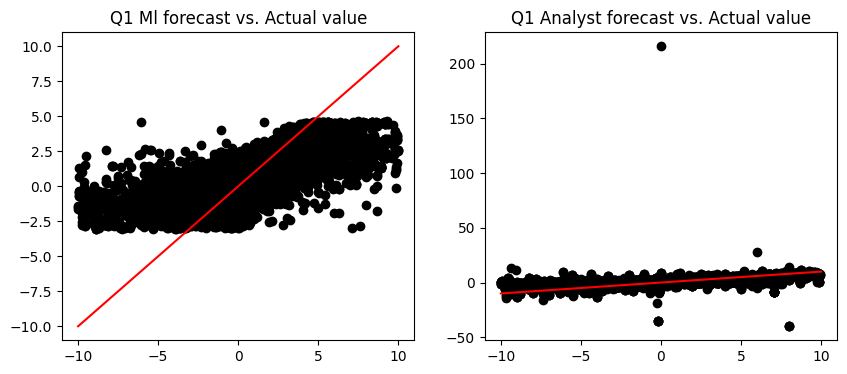

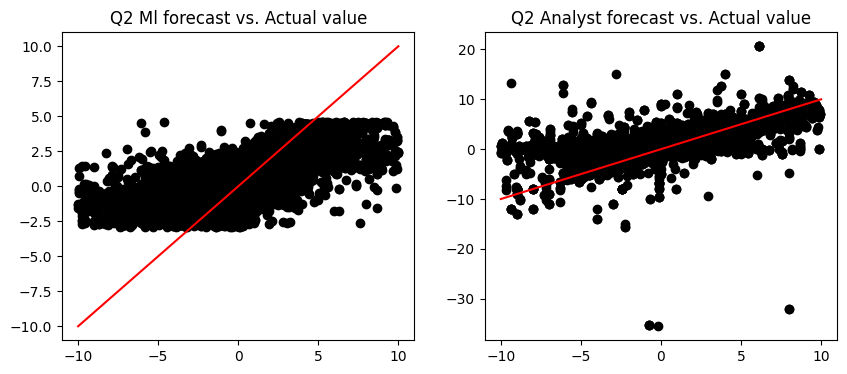

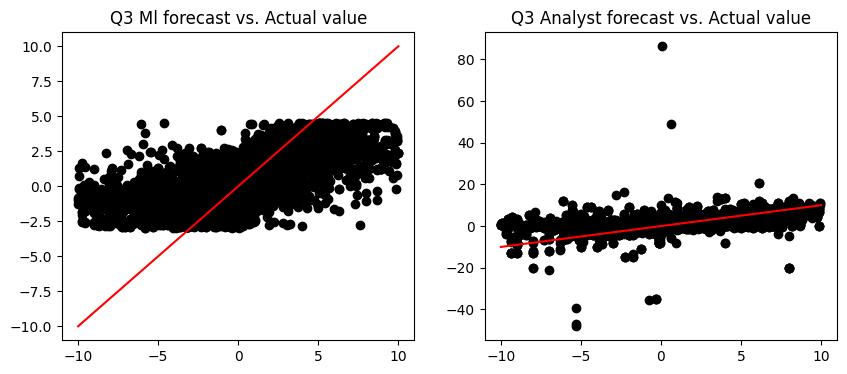

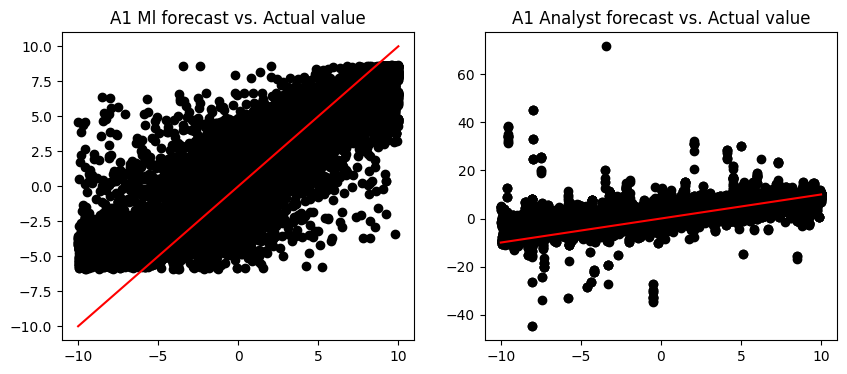

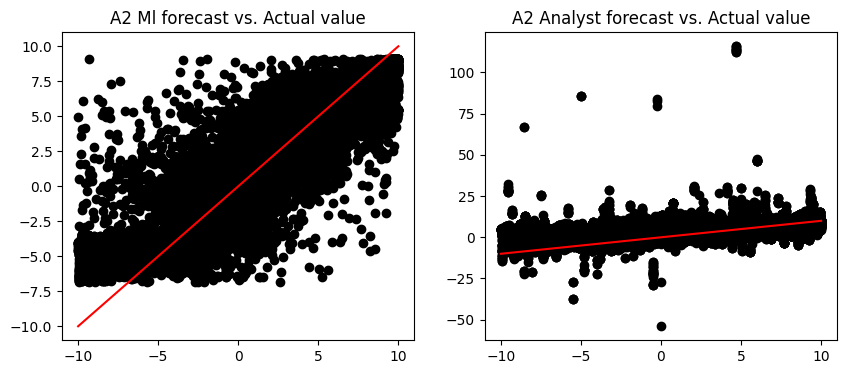

In [8]:
for period in periods:
    fig, ax = plt.subplots(1,2, figsize=(10, 4))
    ax[0].plot(results_rolling[period].adj_actual, results_rolling[period].predicted_adj_actual, 'o', color='black')
    ax[0].plot([-10, 10], [-10, 10], 'r-')
    ax[0].set_title(f'{period} Ml forecast vs. Actual value')
    #ax[0].set_ylim(-10,10)

    print(f' bias for {period}  = {results_rolling[period].biased_expectation.mean()}')

    # plot forecast and exact 
    ax[1].plot(results_rolling[period].adj_actual, results_rolling[period].adj_meanest, 'o', color='black')
    ax[1].plot([-10,10], [-10,10], 'r-')
    ax[1].set_title(f'{period} Analyst forecast vs. Actual value')
   

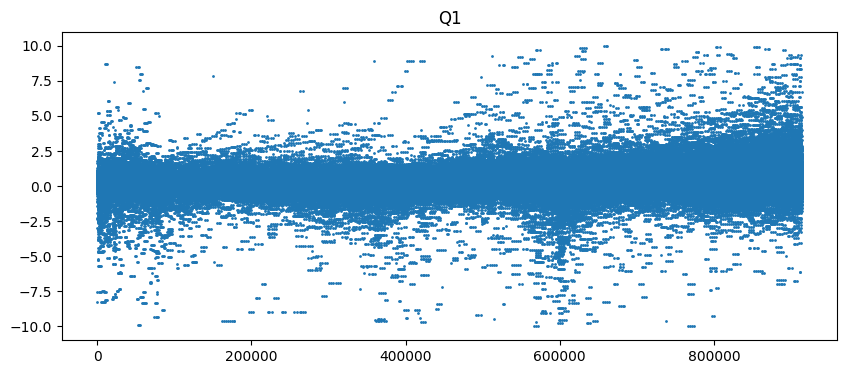

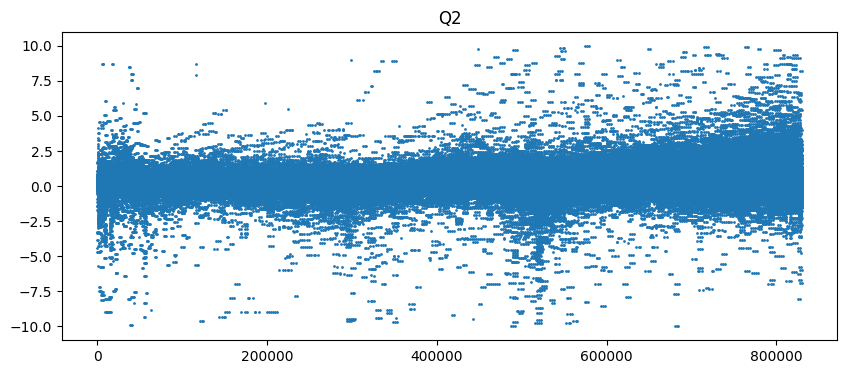

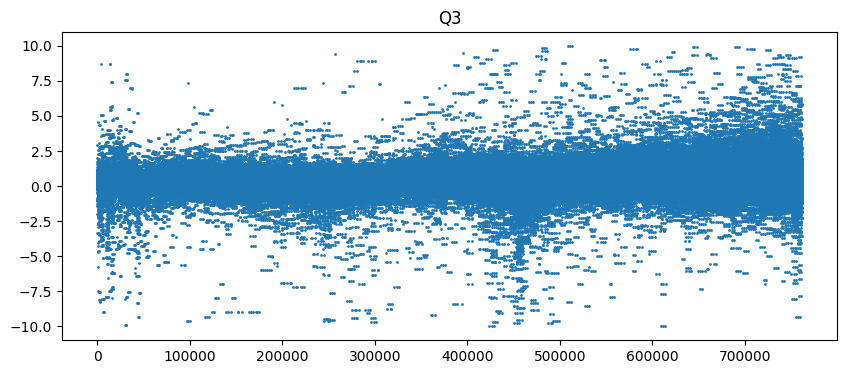

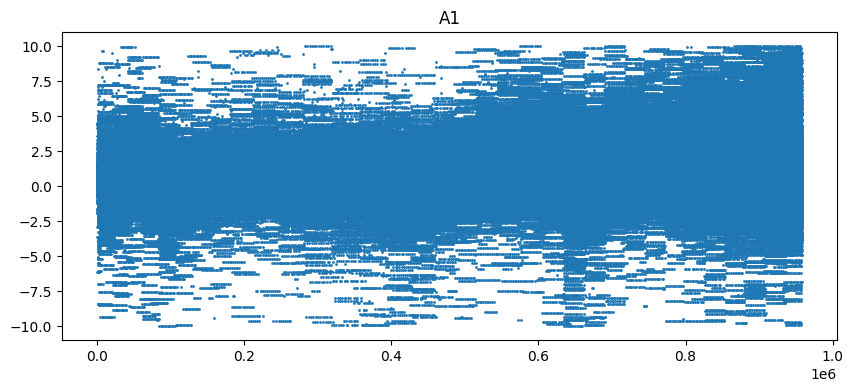

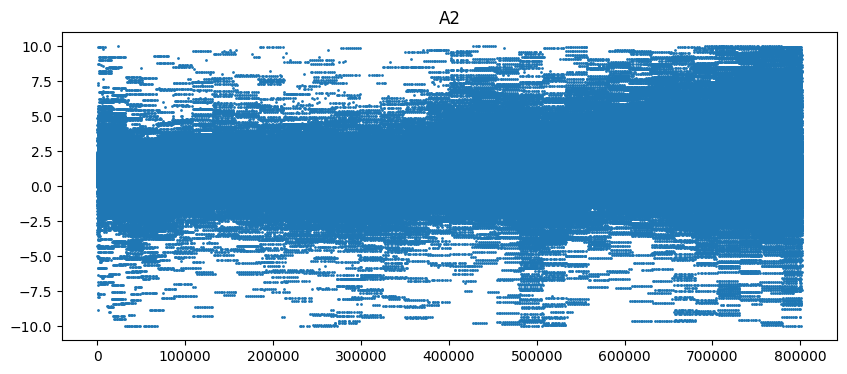

In [9]:
for period, df in results_rolling.items():
    fig, ax = plt.subplots(1,1, figsize=(10, 4))
    plt.scatter(range(len(df)),df.adj_actual, s=1)
    plt.title(period)

In [10]:
for period, df in results_rolling.items():
    print(f' {period} r2_score ml is {r2_score(df.adj_actual, df.predicted_adj_actual)}')
    print(f' {period} r2_score analyst  is {r2_score(df.adj_actual, df.adj_meanest)}')

 Q1 r2_score ml is 0.7608636511858023
 Q1 r2_score analyst  is 0.5596099839693471
 Q2 r2_score ml is 0.7472789403174103
 Q2 r2_score analyst  is 0.6309824348647127
 Q3 r2_score ml is 0.7359822588046281
 Q3 r2_score analyst  is 0.5170273395819963
 A1 r2_score ml is 0.939947410046451
 A1 r2_score analyst  is 0.796736973638279
 A2 r2_score ml is 0.9504033303091963
 A2 r2_score analyst  is 0.44722657186093195


We see our model has better R squared in all the period dataframe. 


The plot also make us udnerstand why the ml preidctions are bounded: as we train on 1% on the train df evrytime, as we see, the majority of oint on whixh we train will be taken froma  subrnage of the all observation range.